In [1]:
from PIL import Image, ImageFont,ImageDraw
import cv2
import numpy as np
import random 
import albumentations as A

/home/void/venv3.12/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_font_path = 'fonts/ArialMT.ttf'

In [3]:
font_size = 16

In [4]:
!ipython kernelspec list

[TerminalIPythonApp] WARNING | File 'kernelspec' doesn't exist
]0;IPython: void/ingos_project-

In [5]:
import numpy as np
import cv2
import albumentations as A
from albumentations.core.transforms_interface import DualTransform

class PrintDefect(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(PrintDefect, self).__init__(always_apply, p)

    def apply(self, image: np.ndarray, **params) -> np.ndarray:
        if image.shape[-1] < 3:
            raise ValueError("The image must have at least 3 channels.")
        
        # Create a copy of the input image and ensure type compatibility
        out = np.copy(image).astype('int16')

        # Generate the spatter effect on a blank image with the same shape as the input
        spatter = A.Spatter(p=1.0)  # Always apply spatter
        spatter_result = spatter(image=np.zeros_like(image[:, :, :3]))

        # Convert the spatter result to grayscale and expand it to 3 channels
        gray_res = cv2.cvtColor(spatter_result['image'], cv2.COLOR_RGB2GRAY)
        gray_res_expanded = np.stack([gray_res] * 3, axis=-1)

        # Subtract the grayscale spatter effect from the original image
        out[:, :, :3] = np.int16(image[:, :, :3]) - gray_res_expanded * 3
        out[:, :, :3] = np.clip(out[:, :, :3], 0, 255)

        return out.astype('uint8')

    def get_transform_init_args_names(self):
        return []

In [6]:

def gen_gaussian(height: int, width: int,sigma=5):
    point_map = np.zeros((height, width), dtype="float64")
    point_map[height // 2, width // 2] = 1
    filter_size = np.array(point_map.shape)
    sigmas = filter_size / sigma
    point_map = cv2.GaussianBlur(point_map, ksize=(0, 0), sigmaY=sigmas[0], sigmaX=sigmas[1])
    point_map = point_map / point_map.max()
    return point_map

def merge_multiline(imgs: list, heatmaps: list) -> tuple[np.ndarray, np.ndarray]:
    spacings = []
    width, height = 0, 0
    for img in imgs:
        img_h, img_w, channels = img.shape
        spacing = np.random.random_integers(5,10) # change TODO
        if img_h + spacing < 0:
            spacing = 0
        spacings.append(spacing)

        width = max(width, img_w)
        height += img_h
        height += spacing
    height -= spacing

    combined_img = np.zeros((height, width, channels), dtype="uint16")
    combined_heatmap = np.zeros((height, width, 2), dtype="float64")
    y_start = 0
    for i, (img, heatmap) in enumerate(zip(imgs, heatmaps)):
        img_h, img_w, _ = img.shape
        x_start = np.random.random_integers(0, width - img_w)
        combined_img[y_start:y_start + img_h, x_start:x_start + img_w, :] += img
        combined_heatmap[y_start:y_start + img_h, x_start:x_start + img_w, :] += heatmap
        y_start += img_h + spacings[i]
    combined_img = np.clip(combined_img, 0, 255).astype("uint8")

    return combined_img, combined_heatmap

def shift(img: np.ndarray, heatmap: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    margins = (15,15) # TODO
    pad_left = np.random.randint(margins[0]) if margins[0] > 0 else 0
    pad_top = np.random.randint(margins[1]) if margins[1] > 0 else 0
    pad_right = np.random.randint(margins[0]) if margins[0] > 0 else 0
    pad_bottom = np.random.randint(margins[1]) if margins[1] > 0 else 0

    h, w, _ = heatmap.shape
    new_w = pad_left + w + pad_right
    new_h = pad_top + h + pad_bottom

    shifted_new_img = np.zeros((new_h, new_w, img.shape[-1]), dtype="uint8")
    shifted_new_img[pad_top:h + pad_top, pad_left:w + pad_left, :] += img

    shifted_heatmap = np.zeros((new_h, new_w, 2))
    shifted_heatmap[pad_top:h + pad_top, pad_left:w + pad_left] += heatmap

    return shifted_new_img, shifted_heatmap

def draw_text_heatmap(text: str, fontpath: str,ignore_list=' ',font_size=32) -> tuple[np.ndarray, np.ndarray]:
    font = ImageFont.truetype(fontpath, size=font_size)
    left, top, right, bottom = font.getbbox(text, anchor="la")
    width, height = right - left, bottom - top
    img = Image.new("RGBA", (right + 5, bottom + 5),(0, 0, 0, 0))  #'white')
    w,h =img.size
    heatmap = np.zeros((h,w,2))
    d = ImageDraw.Draw(img)
    d.text((0, 0), text, font=font, fill=(0, 0, 0, 255))
    
    top, left = 0, 0
    prev_bbox = None
    # print(text)
    for i, char in enumerate(text):
        bbox_1 = font.getbbox(text[i])
        bottom_1 = bbox_1[3] 
        bbox_2 = font.getbbox(text[:i + 1])
        right = bbox_2[2]  #
        bottom_2 = bbox_2[3]
        # bottom_1 = font.getbbox(text[i])[3]
        # right,bottom_2 = font.getbbox(text[:i + 1])[0],font.getbbox(text[:i + 1])[3]
        bottom = bottom_1 if bottom_1 < bottom_2 else bottom_2
        width, height = font.getmask(char).size
        top = bottom - height
        left = right- width
        # print(top,left,bottom, height,right,width)

        if top < 0:
            bottom = bottom - top
            top -= top 
        if char in ignore_list or width == 0 or height == 0:
            # print('con')
            left = right
            prev_bbox = None
            continue
        if left < 0:
            right = right-left
            left -= left
        gaussian = gen_gaussian(bottom - top, right - left)

        heatmap[
            top:bottom,
            left:right,
            0] += gaussian
        
      
        
        if prev_bbox is not None:
            link_center_x = left
            link_center_y = (top + prev_bbox["start_y"]) // 2 + (height + prev_bbox["height"]) // 4
            link_w = min(link_center_x, (width + prev_bbox["width"]) // 4) * 2
        
            link_gaussian = gen_gaussian((height + prev_bbox["height"]) // 2, link_w)
        
            link_h, link_w = link_gaussian.shape
            link_y_start = link_center_y - link_h // 2
            link_x_start = link_center_x - link_w // 2
        
            heatmap[
                link_y_start: link_y_start + link_h,
                link_x_start: link_x_start + link_w,
                1] += link_gaussian
        
        prev_bbox = {"start_x": left, "start_y": top, "width": width, "height": height}
        
    return np.array(img), heatmap#np.array(img.convert(mode='RGB')), heatmap

def pad_to_size(img: Image.Image, size: tuple):
    new_img = Image.new("RGBA", size, (255, 255, 255, 0))
    x_marg = (size[0] - img.size[0]) // 2
    y_marg = (size[1] - img.size[1]) // 2
    new_img.paste(img, (x_marg, y_marg))
    return new_img
def fetch_paper_fragment(img: Image.Image, paper_fname: str, margins: tuple[int, int] = (10, 10)):
    back = Image.open(paper_fname).convert("RGBA")
    size = tuple([d + margin * 2 for d, margin in zip(img.size, margins)])
    if back.size[0] < size[0] or back.size[1] < size[1]:
        back = back.resize(size, Image.Resampling.BICUBIC)
    xrange = back.size[0] - size[0]
    yrange = back.size[1] - size[1]
    x = random.randint(0, xrange)
    y = random.randint(0, yrange)
    return back.crop((x, y, x + size[0], y + size[1]))
def add_paper( img: np.ndarray, margins: tuple[int, int] = None) -> np.ndarray:
    img = Image.fromarray(img)
    paper_path = 'backgpound/test_background.jpg' # TODO change
    margins = margins if margins is not None else margins
    paper = fetch_paper_fragment(img, paper_fname=paper_path, margins=margins)
    img = pad_to_size(img, paper.size)
    img = Image.alpha_composite(paper, img)
    img = np.array(img)
    return img

   
def test(s,test_font_path, aug_do=False) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    imgs = []
    heatmaps = []
    augmentation = A.Compose([
        #TODO
    ])

    for row in s.split('\n'):
        img, heatmap = draw_text_heatmap(row, test_font_path)
        imgs.append(img)
        heatmaps.append(heatmap)

    img, heatmap = merge_multiline(imgs, heatmaps)
    img, heatmap = shift(img, heatmap=heatmap)
    # TODO text and heatmap transform
 
    img = add_paper(img, margins=(0, 0))
    # TODO paper_content_transform
    # TODO paper_perspective_transform
    if aug_do:
        # example aug
        # if you use rotete or crop work with heat map to
        img = augmentation(image=img)['image']
    return np.array(Image.fromarray(img).convert('RGB')),heatmap 
        


In [7]:
def cvt2HeatmapImg(img):
    img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    return img
def add_heatmap2img(img,heatmap):
    color_heatmap = cvt2HeatmapImg(heatmap)
    return cv2.addWeighted(color_heatmap, 0.5,img ,0.5,0)

In [8]:
import string
s = string.ascii_lowercase+'\n'+string.ascii_lowercase.upper() +'\n'+ ''.join(map(str,range(10)))+'\n'+'я русский иду до конца'
s

'abcdefghijklmnopqrstuvwxyz\nABCDEFGHIJKLMNOPQRSTUVWXYZ\n0123456789\nя русский иду до конца'

In [9]:
img, heatmap = test(s,test_font_path)

/tmp/ipykernel_41296/1499176959.py:15: DeprecationWarning: This function is deprecated. Please call randint(5, 10 + 1) instead
  spacing = np.random.random_integers(5,10) # change TODO
/tmp/ipykernel_41296/1499176959.py:30: DeprecationWarning: This function is deprecated. Please call randint(0, 157 + 1) instead
  x_start = np.random.random_integers(0, width - img_w)
/tmp/ipykernel_41296/1499176959.py:30: DeprecationWarning: This function is deprecated. Please call randint(0, 0 + 1) instead
  x_start = np.random.random_integers(0, width - img_w)
/tmp/ipykernel_41296/1499176959.py:30: DeprecationWarning: This function is deprecated. Please call randint(0, 386 + 1) instead
  x_start = np.random.random_integers(0, width - img_w)
/tmp/ipykernel_41296/1499176959.py:30: DeprecationWarning: This function is deprecated. Please call randint(0, 221 + 1) instead
  x_start = np.random.random_integers(0, width - img_w)


In [10]:
img.dtype, heatmap.dtype

(dtype('uint8'), dtype('float64'))

In [11]:
img.shape, heatmap.shape

((183, 574, 3), (183, 574, 2))

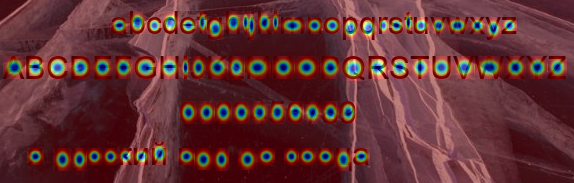

In [12]:
Image.fromarray(add_heatmap2img(img, heatmap[:,:,0])) # text map

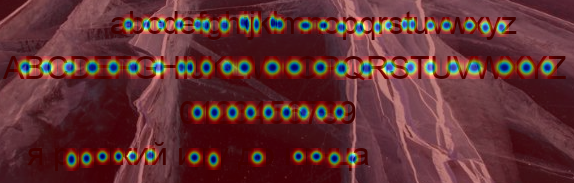

In [13]:
Image.fromarray(add_heatmap2img(img, heatmap[:,:,1])) # link map

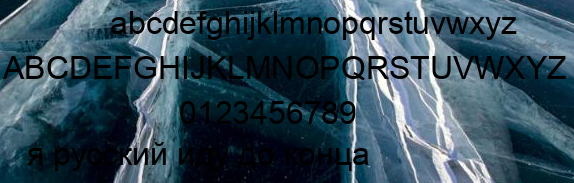

In [14]:
Image.fromarray(img)

In [15]:
Image.fromarray(img).save('test_data/test_img.png') # rewrite

In [20]:
heatmap=heatmap.astype('float32')

In [21]:
np.save('test_data/test_heatmap.npy', heatmap)# rewrite

In [22]:
heatmap.dtype

dtype('float32')

In [23]:
img.shape,heatmap.shape,img.dtype,heatmap.dtype,

((183, 574, 3), (183, 574, 2), dtype('uint8'), dtype('float32'))